In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

In [15]:
# ----- Hyperparameters ----- #
BATCH_SIZE = 1
EPOCHS = 10
LEARNING_RATE = 8e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT = '../celeb_dataset/images'
IMAGE_SIZE = 128
MASK_SIZE = 64
GENERATOR_CHECKPOINT = 'generator.pth'
DISCRIMINATOR_CHECKPOINT = 'discriminator.pth'
SAVE_MODEL = True
LOAD_MODEL = True
TRAIN = False
VISUALIZE_TRAINING = False
print(f'{DEVICE=}')

DEVICE=device(type='cuda')


In [16]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms, image_size, mask_size, mode='train'):
        self.files = os.listdir(root) # generates a list of file names
        split_size = int(len(self.files) * 0.2) # 0.2 is for test-split size
        self.files = self.files[:-split_size] if mode == 'train' else self.files[-split_size:]
        self.mode = mode
        self.transform = transforms
        self.image_size = image_size
        self.mask_size = mask_size
        
    def apply_random_mask(self, image):
        x1,y1 = np.random.randint(0, self.image_size - self.mask_size, 2)
        x2,y2 = x1 + self.mask_size, y1 + self.mask_size
        
        mask_true_value = image[:, y1:y2, x1:x2] # (batch, x1 to x2, y1 to y2)
        masked_image = image.clone()
        masked_image[:, y1:y2, x1:x2] = 1 # sets the masked region to 1
        
        return masked_image, mask_true_value
    
    def apply_center_mask(self, image):
        upper_left = (self.image_size-self.mask_size)//2
        
        mask_true_value = image[:, upper_left:upper_left+self.mask_size, upper_left:upper_left+self.mask_size]
        masked_image = image.clone()
        masked_image[:, upper_left:upper_left+self.mask_size, upper_left:upper_left+self.mask_size] = 1
        
        return masked_image, mask_true_value
    
    def __getitem__(self, index):
        image_file = self.files[index]
        image = Image.open(os.path.join(ROOT, image_file))
        image = self.transform(image)
        
        if self.mode == 'train':
            masked_image, mask_true_value = self.apply_random_mask(image)
            
        else:
            masked_image, mask_true_value = self.apply_center_mask(image)
            
        return masked_image, mask_true_value
    
    def __len__(self):
        return len(self.files)

In [17]:
transforms_ = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

train_dataloader = DataLoader(
    ImageDataset(ROOT, transforms_, IMAGE_SIZE, MASK_SIZE, mode='train'),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    ImageDataset(ROOT, transforms_, IMAGE_SIZE, MASK_SIZE, mode='test'),
    batch_size=5,
    shuffle=True
)

training_visualization_images = next(iter(test_dataloader))

In [18]:
class Generator(nn.Module):
    def __init__(self, channels=3, features=64):
        super().__init__()
        # input size is (batch, 3, 128, 128)
        self.downsample_layers = nn.Sequential(
            nn.Conv2d(channels, features, kernel_size=4, stride=2, padding=1), # (batch, 64, 64, 64)
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features, features, kernel_size=4, stride=2, padding=1), # (batch, 64, 32, 32)
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1), # (batch, 128, 16, 16)
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1), # (batch, 256, 8, 8)
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1), # (batch, 512, 4, 4)
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*8, 4000, kernel_size=4, stride=1, padding=0), # (batch, 4000, 4, 4)
        )
        
        self.upsample_layers = nn.Sequential(
            nn.ConvTranspose2d(4000, features*8, kernel_size=4, stride=1, padding=0), # (batch, 512, 4, 4)
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1), # (batch, 256, 8, 8)
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1), # (batch, 128, 16, 16)
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(features*2, features, kernel_size=4, stride=2, padding=1), # (batch, 64, 32, 32)
            nn.BatchNorm2d(features),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(features, channels, kernel_size=4, stride=2, padding=1), # (batch, 64, 64, 64)
            nn.Tanh(),
        )
        
    def forward(self, x):
        x = self.downsample_layers(x)
        x = self.upsample_layers(x)
        return x

In [19]:
class Discriminator(nn.Module):
    def __init__(self, channels=3, features=64):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(channels, features, kernel_size=4, stride=2, padding=1), # (batch, 64, 32, 32)
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1), # (batch, 128, 16, 16)
            nn.InstanceNorm2d(features*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1), # (batch, 256, 8, 8)
            nn.InstanceNorm2d(features*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1), # (batch, 512, 4, 4)
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*8, 1, kernel_size=4, stride=1, padding=0), # (batch, 1, 1, 1)
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.layers(x)

In [20]:
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

adversarial_loss = nn.BCELoss().to(DEVICE)
pixelwise_loss = nn.L1Loss().to(DEVICE)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [21]:
def train_generator_batch(masked_image, mask_true_value):
    optimizer_generator.zero_grad()
    
    generated_mask_true_value = generator(masked_image)
    discriminator_on_generated = discriminator(generated_mask_true_value)
    
    adversarial_loss_value = adversarial_loss(discriminator_on_generated, torch.ones_like(discriminator_on_generated))
    pixelwise_loss_value = pixelwise_loss(generated_mask_true_value, mask_true_value)
    
    generator_loss = 0.001 * adversarial_loss_value + 0.999 * pixelwise_loss_value
    
    generator_loss.backward()
    optimizer_generator.step()

In [22]:
def train_discriminator_batch(masked_image, mask_true_value):
    optimizer_discriminator.zero_grad()
    
    generated_mask_true_value = generator(masked_image).detach()
    
    discriminator_on_generated = discriminator(generated_mask_true_value)
    discriminator_on_real = discriminator(mask_true_value)
    
    generated_loss = adversarial_loss(discriminator_on_generated, torch.zeros_like(discriminator_on_generated))
    real_loss = adversarial_loss(discriminator_on_real, torch.ones_like(discriminator_on_real))
    
    discriminator_loss = 0.5 * (generated_loss + real_loss)
    discriminator_loss.backward()
    optimizer_discriminator.step()

In [23]:
def fill_mask(masked_image, mask_true_value, upper_left_x, upper_left_y):
    filled_image = masked_image.clone()
    filled_image[:, :, upper_left_y:upper_left_y+MASK_SIZE, upper_left_x:upper_left_x+MASK_SIZE] = mask_true_value
    
    return filled_image

In [24]:
def save_checkpoint(model, optimizer, filename):
    print('\nsaving checkpoint...\n')
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    
    torch.save(checkpoint, filename)
    
def load_checkpoint(model, optimizer, checkpoint_file):
    print('loading checkpoint...')
    model_dict = model.state_dict()
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = LEARNING_RATE # reset the learning rate

In [25]:
if LOAD_MODEL:
    load_checkpoint(generator, optimizer_generator, GENERATOR_CHECKPOINT)
    load_checkpoint(discriminator, optimizer_discriminator, DISCRIMINATOR_CHECKPOINT)

loading checkpoint...
loading checkpoint...


In [26]:
for epoch in range(EPOCHS):
    if not TRAIN:
        break
    loop = tqdm(train_dataloader, total=len(train_dataloader), leave=False)
    
    generator.train()
    discriminator.train()
    
    for batch_index, (masked_image, mask_true_value) in enumerate(loop):
        masked_image = masked_image.to(DEVICE)
        mask_true_value = mask_true_value.to(DEVICE)
        
        train_generator_batch(masked_image, mask_true_value)
        train_discriminator_batch(masked_image, mask_true_value)
        
        loop.set_description(f'Epoch [{epoch}/{EPOCHS}]')
        
    generator.eval()
    if SAVE_MODEL:
        save_checkpoint(generator, optimizer_generator, GENERATOR_CHECKPOINT)
        save_checkpoint(discriminator, optimizer_discriminator, DISCRIMINATOR_CHECKPOINT)
    
    # ----- Visualize the training progress ----- #
    if VISUALIZE_TRAINING: 
        with torch.no_grad():
            upper_left = (IMAGE_SIZE-MASK_SIZE)//2
            
            generated_mask_true_values = generator(training_visualization_images[0].to(DEVICE))
            
            filled_with_reals = fill_mask(training_visualization_images[0], training_visualization_images[1], upper_left, upper_left)
            filled_with_fakes = fill_mask(training_visualization_images[0], generated_mask_true_values, upper_left, upper_left)
            
            grid = make_grid(torch.cat((training_visualization_images[0], filled_with_reals, filled_with_fakes)), nrow=5)
            grid = grid.permute(1,2,0).cpu().numpy()
            plt.imshow(grid)
            _ = plt.xticks([])
            _ = plt.yticks([75, 200, 325], ['masked', 'filled', 'generated'])
            plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


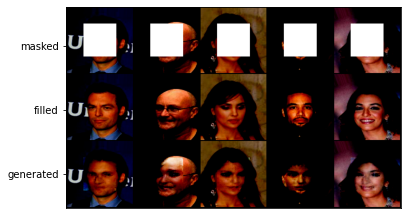

In [27]:
upper_left = (IMAGE_SIZE-MASK_SIZE)//2

generated_mask_true_values = generator(training_visualization_images[0].to(DEVICE))

filled_with_reals = fill_mask(training_visualization_images[0], training_visualization_images[1], upper_left, upper_left)
filled_with_fakes = fill_mask(training_visualization_images[0], generated_mask_true_values, upper_left, upper_left)

grid = make_grid(torch.cat((training_visualization_images[0], filled_with_reals, filled_with_fakes)), nrow=5)
grid = grid.permute(1,2,0).cpu().numpy()
plt.imshow(grid)
_ = plt.xticks([])
_ = plt.yticks([75, 200, 325], ['masked', 'filled', 'generated'])
plt.show()